# Q1. Install the package

In [2]:
import wandb

Question: Once you installed the package, run the command `wandb --version` and check the output.

What's the version that you have?

In [4]:
!wandb --version

wandb, version 0.15.3


> Ans: 0.15.3

In [14]:
!pwd

/home/ubuntu/mlops-zoomcamp/cohorts/2023/02-experiment-tracking/homework-wandb


In [15]:
%%bash 

mkdir data
cd data

wget https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-01.parquet
wget https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-02.parquet
wget https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-03.parquet

--2023-06-01 14:45:21--  https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-01.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 18.244.115.167, 18.244.115.202, 18.244.115.220, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|18.244.115.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1254291 (1.2M) [binary/octet-stream]
Saving to: ‘green_tripdata_2022-01.parquet’

     0K .......... .......... .......... .......... ..........  4% 46.6M 0s
    50K .......... .......... .......... .......... ..........  8% 40.4M 0s
   100K .......... .......... .......... .......... .......... 12%  127M 0s
   150K .......... .......... .......... .......... .......... 16% 71.6M 0s
   200K .......... .......... .......... .......... .......... 20%  142M 0s
   250K .......... .......... .......... .......... .......... 24%  182M 0s
   300K .......... .......... .......... .......... .......... 28%

In [16]:
!pwd
!ls

/home/ubuntu/mlops-zoomcamp/cohorts/2023/02-experiment-tracking/homework-wandb
JG-week2-homework-WandB.ipynb  preprocess_data.py  sweep.py
data			       requirements.txt    train.py


In [17]:
!ls data

green_tripdata_2022-01.parquet	green_tripdata_2022-03.parquet
green_tripdata_2022-02.parquet


In [23]:
!pwd

/home/ubuntu/mlops-zoomcamp/cohorts/2023/02-experiment-tracking/homework-wandb


In [21]:
!cat preprocess_data.py

import os
import pickle
import click
import pandas as pd

import wandb

from sklearn.feature_extraction import DictVectorizer


def dump_pickle(obj, filename: str):
    with open(filename, "wb") as f_out:
        return pickle.dump(obj, f_out)


def read_dataframe(filename: str):
    df = pd.read_parquet(filename)

    df["duration"] = df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ["PULocationID", "DOLocationID"]
    df[categorical] = df[categorical].astype(str)

    return df


def preprocess(df: pd.DataFrame, dv: DictVectorizer, fit_dv: bool = False):
    df["PU_DO"] = df["PULocationID"] + "_" + df["DOLocationID"]
    categorical = ["PU_DO"]
    numerical = ["trip_distance"]
    dicts = df[categorical + numerical].to_dict(orient="records")
    if fit_dv:
        X = dv.fit_transform(dicts)
    else:
        X = dv.transform(dicts)

In [31]:
%%bash

wandb login 56702826232a24ed5fb2e6592219f84f427ecd5b

wandb: Appending key for api.wandb.ai to your netrc file: /home/ubuntu/.netrc


In [32]:
%%bash

python preprocess_data.py \
  --wandb_project mlops-zoomcamp-wandb\
  --wandb_entity jgammerman \
  --raw_data_path /home/ubuntu/mlops-zoomcamp/cohorts/2023/02-experiment-tracking/homework-wandb/data \
  --dest_path ./output

wandb: Currently logged in as: jgammerman. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.3
wandb: Run data is saved locally in /home/ubuntu/mlops-zoomcamp/cohorts/2023/02-experiment-tracking/homework-wandb/wandb/run-20230601_150322-clxgojiq
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run jumping-pine-14
wandb: ⭐️ View project at https://wandb.ai/jgammerman/mlops-zoomcamp-wandb
wandb: 🚀 View run at https://wandb.ai/jgammerman/mlops-zoomcamp-wandb/runs/clxgojiq
wandb: Adding directory to artifact (./output)... Done. 0.0s
wandb: Waiting for W&B process to finish... (success).
wandb: 🚀 View run jumping-pine-14 at: https://wandb.ai/jgammerman/mlops-zoomcamp-wandb/runs/clxgojiq
wandb: Synced 6 W&B file(s), 0 media file(s), 6 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20230601_150322-clxgojiq/logs


Question: Once you navigate to the `Files` tab of your artifact on your Weights & Biases page, what's the size of the saved `DictVectorizer` file?

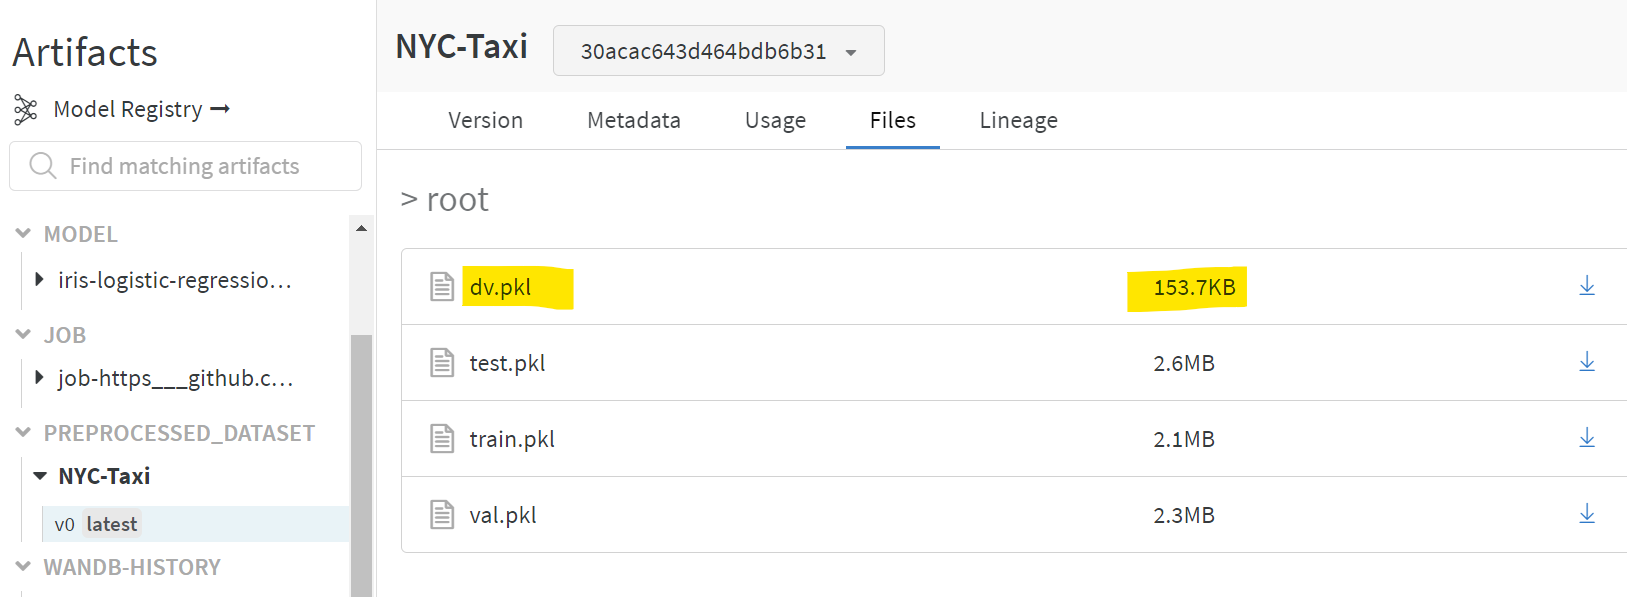

> Answer: 154 kB

# Q3. Train a model with Weights & Biases logging

We will train a `RandomForestRegressor` (from Scikit-Learn) on the taxi dataset.

We have prepared the training script `train.py` for this exercise, which can be also found in the folder `homework-wandb`.

Your task is to modify the script to enable to add Weights & Biases logging, execute the script and then check the Weights & Biases run UI to check that the experiment run was properly tracked.

Once you have successfully ran the script, navigate the Overview section of the run in the Weights & Biases UI and scroll down to the Configs. What is the value of the `max_depth` parameter:

* 4    
* 6  
* 8  
* 10  

In [37]:
!cat train.py

import os
import pickle
import click

import wandb

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


def load_pickle(filename: str):
    with open(filename, "rb") as f_in:
        return pickle.load(f_in)


@click.command()
@click.option("--wandb_project", help="Name of Weights & Biases project")
@click.option("--wandb_entity", help="Name of Weights & Biases entity")
@click.option(
    "--data_artifact",
    help="Address of the Weights & Biases artifact holding the preprocessed data",
)
@click.option("--random_state", default=0, help="Random state")
@click.option("--max_depth", default=10, help="Max tree depth")
def run_train(
    wandb_project: str,
    wandb_entity: str,
    data_artifact: str,
    max_depth: int,
    random_state: int,
):
    # Initialize a Weights & Biases run
    wandb.init(
        project=wandb_project,
        entity=wandb_entity,
        job_type="train",
        config={"max_depth": max_depth, "random_state"

In [35]:
%%bash

python train.py \
  --wandb_project mlops-zoomcamp-wandb \
  --wandb_entity jgammerman \
  --data_artifact "jgammerman/mlops-zoomcamp-wandb/NYC-Taxi:v0"

wandb: Currently logged in as: jgammerman. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.3
wandb: Run data is saved locally in /home/ubuntu/mlops-zoomcamp/cohorts/2023/02-experiment-tracking/homework-wandb/wandb/run-20230601_152932-zys8zxc5
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run polar-waterfall-16
wandb: ⭐️ View project at https://wandb.ai/jgammerman/mlops-zoomcamp-wandb
wandb: 🚀 View run at https://wandb.ai/jgammerman/mlops-zoomcamp-wandb/runs/zys8zxc5
wandb:   4 of 4 files downloaded.  
wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb: MSE ▁
wandb: 
wandb: Run summary:
wandb: MSE 2.45398
wandb: 
wandb: 🚀 View run polar-waterfall-16 at: https://wandb.ai/jgammerman/mlops-zoomcamp-wandb/runs/zys8zxc5
wandb: Synced 6 W&B file(s), 0 media file(s), 3 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20230601_152932-zys8zxc5/logs


Screenshot showing the answer:

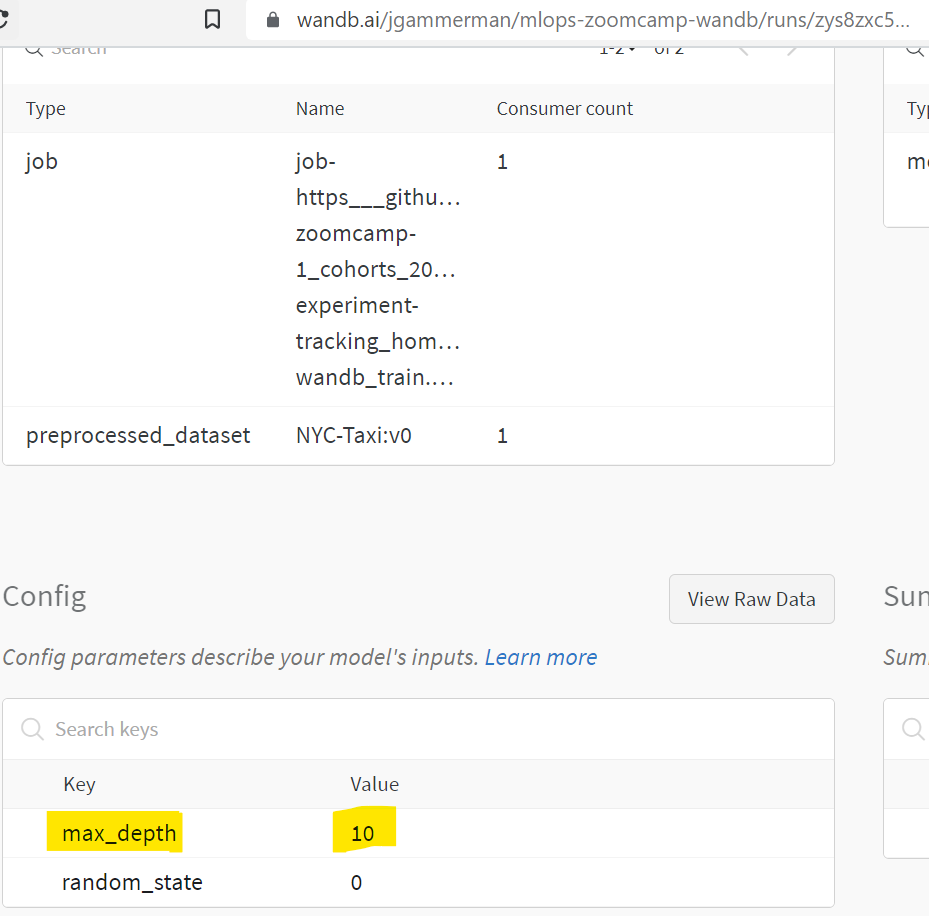

> Answer: 10

# Q4. Tune model hyperparameters

Now let's try to reduce the validation error by tuning the hyperparameters of the `RandomForestRegressor` using Weights & Biases Sweeps. We have prepared the script `sweep.py` for this exercise in the `homework-wandb` directory.

Your task is to modify `sweep.py` to pass the parameters `n_estimators`, `min_samples_split` and `min_samples_leaf` from config to `RandomForestRegressor` inside the `run_train()` function. Then we will run the sweep to figure out not only the best best of hyperparameters for training our model, but also to analyze the most optimum trends in different hyperparameters.

After modifying the script, you can take a look at the sweep on your Weights & Biases dashboard, take a look at the **Parameter Inportance Panel** and the **Parallel Coordinates Plot** to determine, and analyze which hyperparameter is the most important:

* max_depth
* n_estimators
* min_samples_split
* min_samples_leaf


Here is my modified code:

In [38]:
!cat sweep.py

import os
import pickle
import click
from functools import partial

import wandb

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


def load_pickle(filename: str):
    with open(filename, "rb") as f_in:
        return pickle.load(f_in)


def run_train(data_artifact: str):
    wandb.init()
    config = wandb.config

    # Fetch the preprocessed dataset from artifacts
    artifact = wandb.use_artifact(data_artifact, type="preprocessed_dataset")
    data_path = artifact.download()

    X_train, y_train = load_pickle(os.path.join(data_path, "train.pkl"))
    X_val, y_val = load_pickle(os.path.join(data_path, "val.pkl"))

    # Define the XGBoost Regressor Mode, train the model and perform prediction
    # TODO: Pass the parameters n_estimators, min_samples_split, min_samples_leaf from `config` to `RandomForestRegressor`
    rf = RandomForestRegressor(
        max_depth=config.max_depth, 
        n_estimators=config.n_estimators,
        min

In [40]:
%%bash

python sweep.py \
  --wandb_project mlops-zoomcamp-wandb \
  --wandb_entity jgammerman \
  --data_artifact "jgammerman/mlops-zoomcamp-wandb/NYC-Taxi:v0"

wandb: Agent Starting Run: sbpjv1ev with config:
wandb: 	max_depth: 6
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 50
wandb: Currently logged in as: jgammerman. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.3
wandb: Run data is saved locally in /home/ubuntu/mlops-zoomcamp/cohorts/2023/02-experiment-tracking/homework-wandb/wandb/run-20230601_154758-sbpjv1ev
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run morning-sweep-1
wandb: ⭐️ View project at https://wandb.ai/jgammerman/mlops-zoomcamp-wandb
wandb: 🧹 View sweep at https://wandb.ai/jgammerman/mlops-zoomcamp-wandb/sweeps/46a4dgf8
wandb: 🚀 View run at https://wandb.ai/jgammerman/mlops-zoomcamp-wandb/runs/sbpjv1ev
wandb:   4 of 4 files downloaded.  
wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb: MSE ▁
wandb: 
wandb: Run summary:
wandb: MSE 2.45786
wandb: 
wandb: 🚀 View run morning-sweep-1 at: https://w

Create sweep with ID: 46a4dgf8
Sweep URL: https://wandb.ai/jgammerman/mlops-zoomcamp-wandb/sweeps/46a4dgf8


Screenshot showing answer:

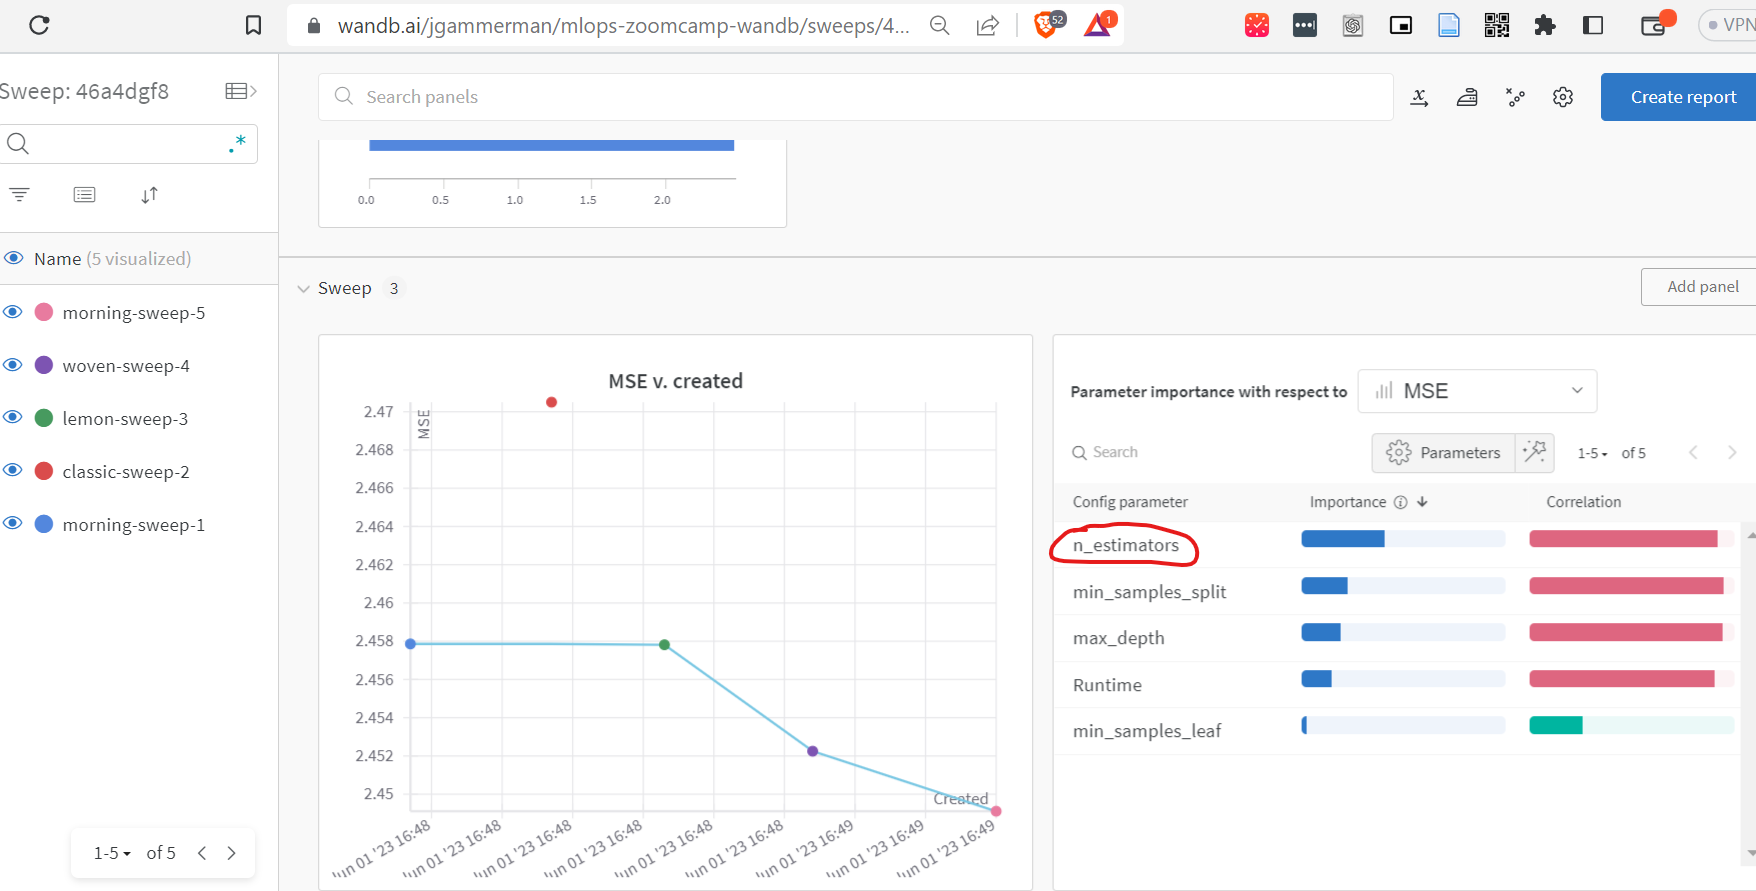

> Answer: n_estimators

# Q5. Link the best model to the model registry

Now that we have obtained the optimal set of hyperparameters and trained the best model, we can assume that we are ready to test some of these models in production. In this exercise, you'll create a model registry and link the best model from the Sweep to the model registry...

Question:

Now that the model artifact is linked to the Registered Model, which of these information do we see on the Registered Model UI?

* Versioning
* Metadata
* Aliases
* Metric (MSE)
* Source run
* All of these
* None of these

Screenshot showing answer:

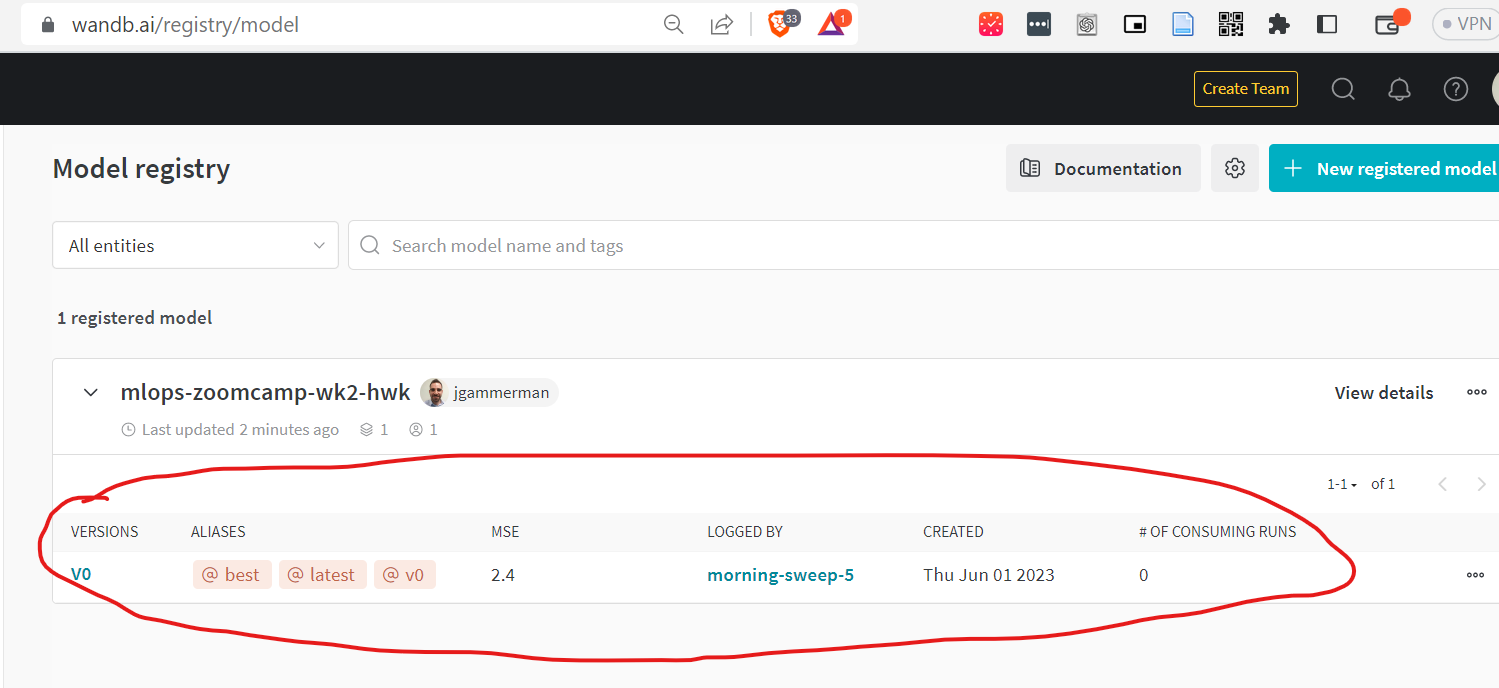

> Answer: All of them